<center>                                       <H1>Validation of the NN code generator for the 2D diffusion equation </H1> 
    <H3>O. Pannekoucke</H3> 
</center>
$   %\newcommand{\pde}{\partial}
    %\newcommand{\pdt}{\partial_t}
    %\newcommand{\pdx}{\partial_x}
    \newcommand{\bu}{\bar u}
    \newcommand{\eps}{\varepsilon}$

<center> <b>Objectifs</b> </center>

 * Definition of the 2D diffusion equation by using `sympy`
 * Computation of the numerical solution of the 2D diffusion using a NN

--- 
<h1><center>Contents</center></h1>


  1. [Introduction](#intro)
  1. [Dynamics](#model)
  1. [Numerical code for the resolution](#code)
  1. [Numerical application](#num)
  1. [Conclusion](#conclusion)
---

## Introduction <a id='intro'/>

The aim is to compute the solution of the diffusion equation given by
$$\partial_t u = \partial_{x^i}\left(\kappa_{ij}\partial_{x^j} u \right),$$
where $\kappa$  is a field of diffusion tensors.

## Dynamics <a id='model'>

In [1]:
from sympy import init_printing
init_printing() 

**Set the diffusion equation**

In [2]:
from sympy import Function, symbols, Derivative
from pdenetgen import Eq, NNModelBuilder

# Defines the diffusion equation using sympy
t, x, y = symbols('t x y')
u = Function('u')(t,x,y)
kappa11 = Function('\\kappa_{11}')(x,y)
kappa12 = Function('\\kappa_{12}')(x,y)
kappa22 = Function('\\kappa_{22}')(x,y)

diffusion_2D = Eq(Derivative(u,t),
  Derivative(kappa11*Derivative(u,x)+
             kappa12*Derivative(u,y),x)+
  Derivative(kappa12*Derivative(u,x)+
             kappa22*Derivative(u,y),y)).doit()

# Defines the neural network code generator
diffusion_nn_builder = NNModelBuilder(diffusion_2D,
        class_name="NNDiffusion2DHeterogeneous")

# Renders the neural network code
exec(diffusion_nn_builder.code)

# Create a 2D Diffusion model
diffusion_model = NNDiffusion2DHeterogeneous()

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

**Sample of NN code generated**
```python
# Example of computation of a derivative
kernel_Du_x_o1 = np.asarray([[0.0,-1/(2*self.dx[self.coordinates.index('x')]),0.0],
 [0.0,0.0,0.0],
 [0.0,1/(2*self.dx[self.coordinates.index('x')]),0.0]]).reshape((3, 3)+(1,1))
Du_x_o1 = DerivativeFactory((3, 3),kernel=kernel_Du_x_o1,name='Du_x_o1')(u)

# Computation of trend_u
mul_0 = keras.layers.multiply([Dkappa_11_x_o1,Du_x_o1],name='MulLayer_0')
mul_1 = keras.layers.multiply([Dkappa_12_x_o1,Du_y_o1],name='MulLayer_1')
mul_2 = keras.layers.multiply([Dkappa_12_y_o1,Du_x_o1],name='MulLayer_2')
mul_3 = keras.layers.multiply([Dkappa_22_y_o1,Du_y_o1],name='MulLayer_3')
mul_4 = keras.layers.multiply([Du_x_o2,kappa_11],name='MulLayer_4')
mul_5 = keras.layers.multiply([Du_y_o2,kappa_22],name='MulLayer_5')
mul_6 = keras.layers.multiply([Du_x_o1_y_o1,kappa_12],name='MulLayer_6')
sc_mul_0 = keras.layers.Lambda(lambda x: 2.0*x,name='ScalarMulLayer_0')(mul_6)
trend_u = keras.layers.add([mul_0,mul_1,mul_2,mul_3,mul_4,mul_5,sc_mul_0],name='AddLayer_0')
```

In [3]:
print(diffusion_nn_builder.code)

from pdenetgen.model import Model
import numpy as np
import keras
from pdenetgen.symbolic.nn_builder import DerivativeFactory, TrainableScalarLayerFactory

class NNDiffusion2DHeterogeneous(Model):

    # Prognostic functions (sympy functions):
    prognostic_functions = (
            'u',    # Write comments on the function here
        )

    
    
    # Spatial coordinates
    coordinates = (
            'x',    # Write comments on the coordinate here
            'y',    # Write comments on the coordinate here
        )

    
    # Set constant functions
    constant_functions = (
            'kappa_11',    # Writes comment on the constant function here
            'kappa_12',    # Writes comment on the constant function here
            'kappa_22',    # Writes comment on the constant function here
        )
    

    

    def __init__(self, shape=None, lengths=None, **kwargs):

        super().__init__() # Time scheme is set from Model.__init__()
                
        #---------

## Numerical application <a id='num'/>

### Definition of the domain of computation

The domain is the bi-periodic sqare $[0,1)\times [0,1)$

### Set the numerical NN model

In [4]:
domain = diffusion_model

**Set initial fields**

In [5]:
import numpy as np

In [6]:
dx, dy = diffusion_model.dx

# Set a dirac at the center of the domain.
U = np.zeros(diffusion_model.shape)
U[diffusion_model.shape[0]//2, diffusion_model.shape[0]//2] = 1./(dx*dy)



In [7]:
diffusion_model.shape

In [8]:
X = np.asarray(diffusion_model.X)
k = np.asarray([1,2])
X = np.moveaxis(X,0,2)
print(X.shape)

np.linalg.norm(X@k -k[0]*diffusion_model.X[0]-k[1]*diffusion_model.X[1])

(100, 100, 2)


**Set constants and time step**

In [9]:
import matplotlib.pyplot as plt

In [10]:
time_scale = 1.
#
# Construction du tenseur de diffusion
#

# a) Définition des composantes principales
lx, ly = 10*dx, 5*dy
kappa_11 = lx**2/time_scale
kappa_22 = ly**2/time_scale

# b) Construction d'un matrice de rotation
R = lambda theta : np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

# c) Spectre du tenseur de référence
D = np.diag([kappa_11,kappa_22])


# d) Set diffusion tensors field
diffusion_model.kappa_11 = np.zeros(diffusion_model.shape)
diffusion_model.kappa_12 = np.zeros(diffusion_model.shape)
diffusion_model.kappa_22 = np.zeros(diffusion_model.shape)

X = np.moveaxis(np.asarray(diffusion_model.X),0,2)
k = 2*np.pi*np.array([2,3])

theta = np.pi/3*np.cos(X@k)
#plt.contourf(*num_model.x, theta)

for i in range(diffusion_model.shape[0]):
    for j in range(diffusion_model.shape[1]):
        lR = R(theta[i,j])
        nu = lR@np.diag([kappa_11,kappa_22])@lR.T
        diffusion_model.kappa_11[i,j] = nu[0,0]
        diffusion_model.kappa_12[i,j] = nu[0,1]
        diffusion_model.kappa_22[i,j] = nu[1,1]
        
        
diffusion_model.kappa_11 = diffusion_model.kappa_11.reshape((1,100,100,1))
diffusion_model.kappa_12 = diffusion_model.kappa_12.reshape((1,100,100,1))
diffusion_model.kappa_22 = diffusion_model.kappa_22.reshape((1,100,100,1))
#
# Calcul du pas de temps adapté au problème
#
dt = np.min([dx**2/kappa_11, dy**2/kappa_22])

CFL = 1/6
diffusion_model._dt = CFL * dt
print('time step:', diffusion_model._dt)

time step: 0.0016666666666666663


**Illustrates trend at initial condition**

In [11]:
def plot(field):
    plt.contourf(*diffusion_model.x, field.T)

In [12]:
state0 = U.copy().reshape((1,1)+diffusion_model.shape+(1,))
print(state0.shape)

(1, 1, 100, 100, 1)


In [13]:
import keras

Instructions for updating:
Colocations handled automatically by placer.


Text(0.5, 1.0, 'Trend for the diffusion')

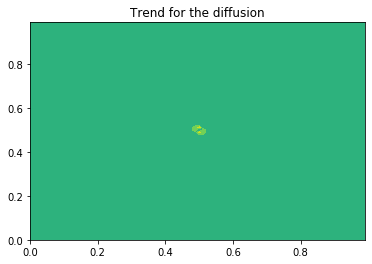

In [14]:
dU, = diffusion_model.trend(0,state0)

plot(dU[0].reshape((100,100)))
plt.title('Trend for the diffusion')

**Short forecast**

In [15]:
times = diffusion_model.window(time_scale)
#saved_times = times[::100]
saved_times = times

In [16]:
diffusion_model.set_time_scheme('euler')
traj = diffusion_model.forecast(times, state0, saved_times)

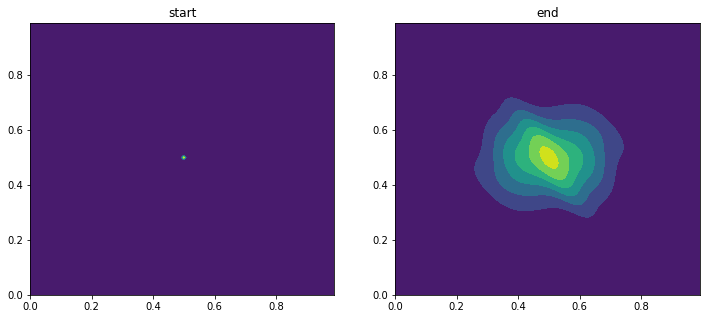

In [17]:
plt.figure(figsize=(12,5))

start, end = [traj[time] for time in [saved_times[0], saved_times[-1]]]

title = ['start', 'end']
for k, state in enumerate([start, end]):
    plt.subplot(121+k)
    plot(state[0].reshape((100,100)))
    plt.title(title[k])
    
plt.savefig('./figures/NN-diffusion-2D-prediction.pdf')
np.save('nn-diffusion.npy', end)

**Comparison with the finite difference solution**

In [18]:
fd_end_solution = np.load('fd-diffusion.npy')

In [19]:
np.linalg.norm(fd_end_solution[0] - end[0,0,:,:,0])

## Conclusion <a id='conclusion'/>

In this notebook, the solution of the diffusion equation using a NN code has been presented. 
The results are those of the finite-difference solution (not shown here). This validate the NN generator and illustrates how the physical equations can be used for the design of a NN architecture.